### Select and Plot Data at Time Series Location During CANON Spring 2018
*Several platforms visited the same geographic location - retreive all the data from this location and compare*


Executing this Notebook requires a personal STOQS server.  The Docker instructions below will give you a personal server and your own copy of the database.

#### Docker Instructions
With your stoqs server running in Docker as 
[detailed in the README](https://github.com/stoqs/stoqs#production-deployment-with-docker) load a copy of the stoqs_canon_may2018 database (from your `$STOQS_HOME/docker` directory) :

    docker-compose exec stoqs createdb -U postgres stoqs_canon_may2018
    curl -k https://stoqs.mbari.org/media/pg_dumps/stoqs_canon_may2018.pg_dump | \
        docker exec -i stoqs pg_restore -Fc -U postgres -d stoqs_canon_may2018
        
This may take 10 minutes or more to complete - wait for the command prompt. Then launch the Jupyter Notebook server:

    docker-compose exec stoqs stoqs/manage.py shell_plus --notebook

A message is displayed giving a token for you to use in a browser on your host, e.g.:

    http://localhost:8888/?token=<use_the_given_one-time_token>

In the browser window navigate to this file (`stoqs/contrib/notebooks/geospatial_sample_selection_may2018.ipynb`) and open it. You will then be able to execute the cells and experiment with this notebook.

---

Find all the data within 1 km of the center of the Makai ESP Samples (time series location): -122.520, 36.980

In [4]:
db = 'stoqs_canon_may2018'

from django.contrib.gis.geos import fromstr
from django.contrib.gis.measure import D

ts_loc = fromstr('POINT(-122.520 36.980)')
near_ts_loc = Measurement.objects.using(db).filter(geom__distance_lt=(ts_loc, D(km=1.0)))

In [5]:
acts = Activity.objects.using(db).filter(instantpoint__measurement__in=near_ts_loc)

In [6]:
acts.values_list('platform__name', flat=True).distinct()

<QuerySet ['makai_ESP_Archive', 'WesternFlyer_UCTD', 'WesternFlyer_PCTD', 'wg_Sparky_Glider', 'NPS_Glider_34', 'makai', 'wg_Tiny_Glider', 'daphne']>

In [7]:
pctds = acts.filter(platform__name='WesternFlyer_PCTD').order_by('startdate').distinct()
esps = acts.filter(platform__name='makai_ESP_Archive').order_by('startdate').distinct()

In [9]:
pctds

<QuerySet [<Activity: cn18sc09>, <Activity: cn18sc10>, <Activity: cn18sc12>, <Activity: cn18sc14>, <Activity: cn18sc18>, <Activity: cn18sc24>, <Activity: cn18sc27>, <Activity: cn18sc35>, <Activity: cn18sc37>, <Activity: cn18sc40>]>

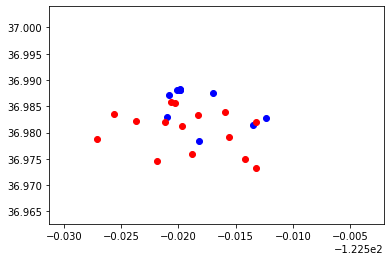

In [8]:
%matplotlib inline
import pylab as plt
plt.scatter([pctd.mappoint.x for pctd in pctds],
            [pctd.mappoint.y for pctd in pctds], c='b')
plt.scatter([esp.mappoint.x for esp in esps],
            [esp.mappoint.y for esp in esps], c='r')

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import pylab
from numpy import arange
import operator

def plot_platforms(ax):
    plat_labels = []

    # Plot in order by platformtype name and platform name
    for ypos, plat in enumerate(
                        sorted(plat_start_ends.keys(),
                               key=operator.attrgetter('platformtype.name', 'name'))):
        plat_labels.append(f'{plat.name} ({plat.platformtype.name})')    
        for bdate, edate in plat_start_ends[plat]:
            dd = edate - bdate
            if dd < 1:
                dd = 1
            ax.barh(ypos+0.5, dd, left=bdate, height=0.8, 
                    align='center', color='#' + plat.color, alpha=1.0) 

    ax.set_title(Campaign.objects.using(db).get(id=1).description)
    ax.set_ylim(-0.5, len(plat_labels) + 0.5)
    ax.set_yticks(arange(len(plat_labels)) + 0.5)
    ax.set_yticklabels(plat_labels)

    ax.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
    plt.gcf().autofmt_xdate()

pylab.rcParams['figure.figsize'] = (15, 9)
fig, ax = plt.subplots()
plot_platforms(ax)
plt.show()

There appear to be 10 events measured by the Benthic Event Detectors. Let's find the start times for these events and use _k_-means clustering to group the BEDs event data start times into 10 clusters.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
bed_starts = np.array(Activity.objects.using(db)
                              .filter(platform__name__contains='BED')
                              .values_list('startdate', flat=True)
                              .order_by('startdate'), dtype=np.datetime64)
km = KMeans(n_clusters=10).fit(bed_starts.reshape(-1, 1))

Pick the earliest event start time and construct start and end times that we'll use to instruct the STOQS loader that these are the times when we want to load ADCP data from all the moorings into the database.

In [ ]:
events = {}
for bed_start in bed_starts:
    label = km.predict(bed_start.reshape(-1, 1))[0]
    if label not in events.keys():
        events[label] = bed_start
    # Print the clusters of start times and tune n_clusters above to get the optimal set
    ##print(bed_start, label)

Print `Event()` instances of begining and end times for use in [loadCCE_2015.py](https://github.com/stoqs/stoqs/blob/3a596e6791104054c676a0ba84e81ec02b7ca06b/stoqs/loaders/CCE/loadCCE_2015.py#L23-L32)

In [ ]:
from datetime import datetime, timedelta
event_start_ends = defaultdict(list)
def print_Events(events, before, after, type):
    for start in events.values():
        beg_dt = repr(start.astype(datetime) - before).replace('datetime.', '')
        end_dt = repr(start.astype(datetime) + after).replace('datetime.', '')
        event_start_ends[type].append((mdates.date2num(start.astype(datetime) - before),
                                       mdates.date2num(start.astype(datetime) + after)))
        print(f"        Event({beg_dt}, {end_dt}),")

# Low-resolution region: 1 day before to 2 days after the start of each event
before = timedelta(days=1)
after = timedelta(days=2)
print("lores_event_times = [")
print_Events(events, before, after, 'lores')
print("                    ]")

# High-resolution region: 4 hours before to 14 hours after the start of each event
before = timedelta(hours=4)
after = timedelta(hours=14)
print("hires_event_times = [")
print_Events(events, before, after, 'hires')
print("                    ]")

Plot timeline again, but this time with events as shaded regions across all the Platforms.

In [ ]:
def plot_events(ax):
    for type in ('lores', 'hires'):
        for bdate, edate in event_start_ends[type]:
            dd = edate - bdate
            if dd < 1:
                dd = 1
            # Plot discovered events as gray lines across all platforms
            ax.barh(0, dd, left=bdate, height=32, 
                    align='center', color='#000000', alpha=0.1) 

pylab.rcParams['figure.figsize'] = (15, 9)
fig, ax2 = plt.subplots()
plot_platforms(ax2)
plot_events(ax2)
plt.show()